# Machine Learning for Perovskite Materials

The dataset was already published by Antoine Emery: High-throughput DFT calculations of formation energy, stability and oxygen vacancy formation energy of ABO3 perovskites, from figshare. Dataset. https://doi.org/10.6084/m9.figshare.5334142.v1 

The link to this dataset was found from **matminer**, a Python library for data mining the properties of materials (L. Ward et al, Matminer: An open source toolkit for materials data mining. Comput. Mater. Sci. 152, 60-69 (2018)) 


## Section 1: Data Manupulation

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


### Section 1-1: Data Loading and Primary Observations

In [2]:
#Loading data from local folder
df=pd.read_csv("HighthroughputDFTcalculations.csv")

df.head(5)

,Chemical formula,A,B,In literature,Valence A,Valence B,Radius A [ang],Radius B [ang],Lowest distortion,Formation energy [eV/atom],...,Magnetic moment [mu_B],Volume per atom [A^3/atom],Band gap [eV],a [ang],b [ang],c [ang],alpha [deg],beta [deg],gamma [deg],Vacancy energy [eV/O atom]
0,Ac2O3,Ac,Ac,False,element not in BV,element not in BV,1.12,1.12,cubic,-2.732,...,0.000,20.836,0.332,4.705,4.705,4.705,90.0,90.0,90.0,3.150
1,AcAgO3,Ac,Ag,False,element not in BV,element not in BV,1.12,0.95,orthorhombic,-1.957,...,0.000,14.485,0.000,5.779,6.077,8.248,90.0,90.0,90.0,0.817
2,AcAlO3,Ac,Al,False,element not in BV,element not in BV,1.12,0.54,cubic,-3.532,...,0.000,11.487,4.307,3.858,3.858,3.858,90.0,90.0,90.0,6.695
3,AcAsO3,Ac,As,False,element not in BV,element not in BV,1.12,0.52,orthorhombic,-2.398,...,0.000,14.355,0.000,5.780,6.012,8.262,90.0,90.0,90.0,3.634
4,AcAuO3,Ac,Au,False,element not in BV,element not in BV,1.12,0.93,orthorhombic,-2.006,...,0.000,15.190,0.745,5.899,6.750,7.630,90.0,90.0,90.0,0.807


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5329 entries, 0 to 5328
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Chemical formula            5329 non-null   object 
 1   A                           5329 non-null   object 
 2   B                           5329 non-null   object 
 3   In literature               5329 non-null   bool   
 4   Valence A                   5329 non-null   object 
 5   Valence B                   5329 non-null   object 
 6   Radius A [ang]              5329 non-null   float64
 7   Radius B [ang]              5329 non-null   float64
 8   Lowest distortion           5329 non-null   object 
 9   Formation energy [eV/atom]  5329 non-null   object 
 10  Stability [eV/atom]         5329 non-null   object 
 11  Magnetic moment [mu_B]      5329 non-null   object 
 12  Volume per atom [A^3/atom]  5329 non-null   object 
 13  Band gap [eV]               5329 

### Section 1-2: Data Cleaning 

In [5]:

#columns to be encoded to numeric
col_change=['Formation energy [eV/atom]','Stability [eV/atom]',
       'Magnetic moment [mu_B]', 'Volume per atom [A^3/atom]', 'Band gap [eV]',
       'a [ang]', 'b [ang]', 'c [ang]', 'alpha [deg]', 'beta [deg]',
       'gamma [deg]', 'Vacancy energy [eV/O atom]']

for i in col_change:
    df[i]=pd.to_numeric(df[i], errors="coerce")
    
# The LowestDist is linked to crystallography of the materials and in the dataset, there are many features which
# might have underlying interaction with LowestDist. The question is that how the crystal structure of the material can
# influence the properties of the materials.So the LowetDsit is a our target label.  

# Since the unique values of label are low, it is possible to apply manual ordinal encoding. 

ordinal_encoding={"cubic":1, "orthorhombic":2, "rhombohedral":3,"tetragonal":4,"-":5 }
df["LowestDist"]=df["Lowest distortion"].replace(ordinal_encoding)

#col_obj contains features which are numeric and will be used for the model training. The new dataframe is called DFT.

col_obj=[col for col in df.columns if df[col].dtypes in ["float64", "int64"]]
DFT=df[col_obj]   #  new DataFrame

#Missing Values

#The feature "Magnetic moment" has large percentage missing values, and currently it is not our focus. 

DFT=DFT.drop("Magnetic moment [mu_B]", axis=1)
DFT=DFT.dropna(axis=0)

#Defining Features and Label

features=DFT.drop("LowestDist", axis=1)
labels=DFT["LowestDist"]

# Train Test split for the features and lables
X_train, X_test, y_train, y_test=train_test_split(features, labels, test_size=0.3, random_state=42, stratify=labels)


### Section 1-3: Correlation to the label

The pairplot is divided into two plots for better visualization. The first plot shows positive correlation between features and the label and the second plot for those features with negative correlation to the label.

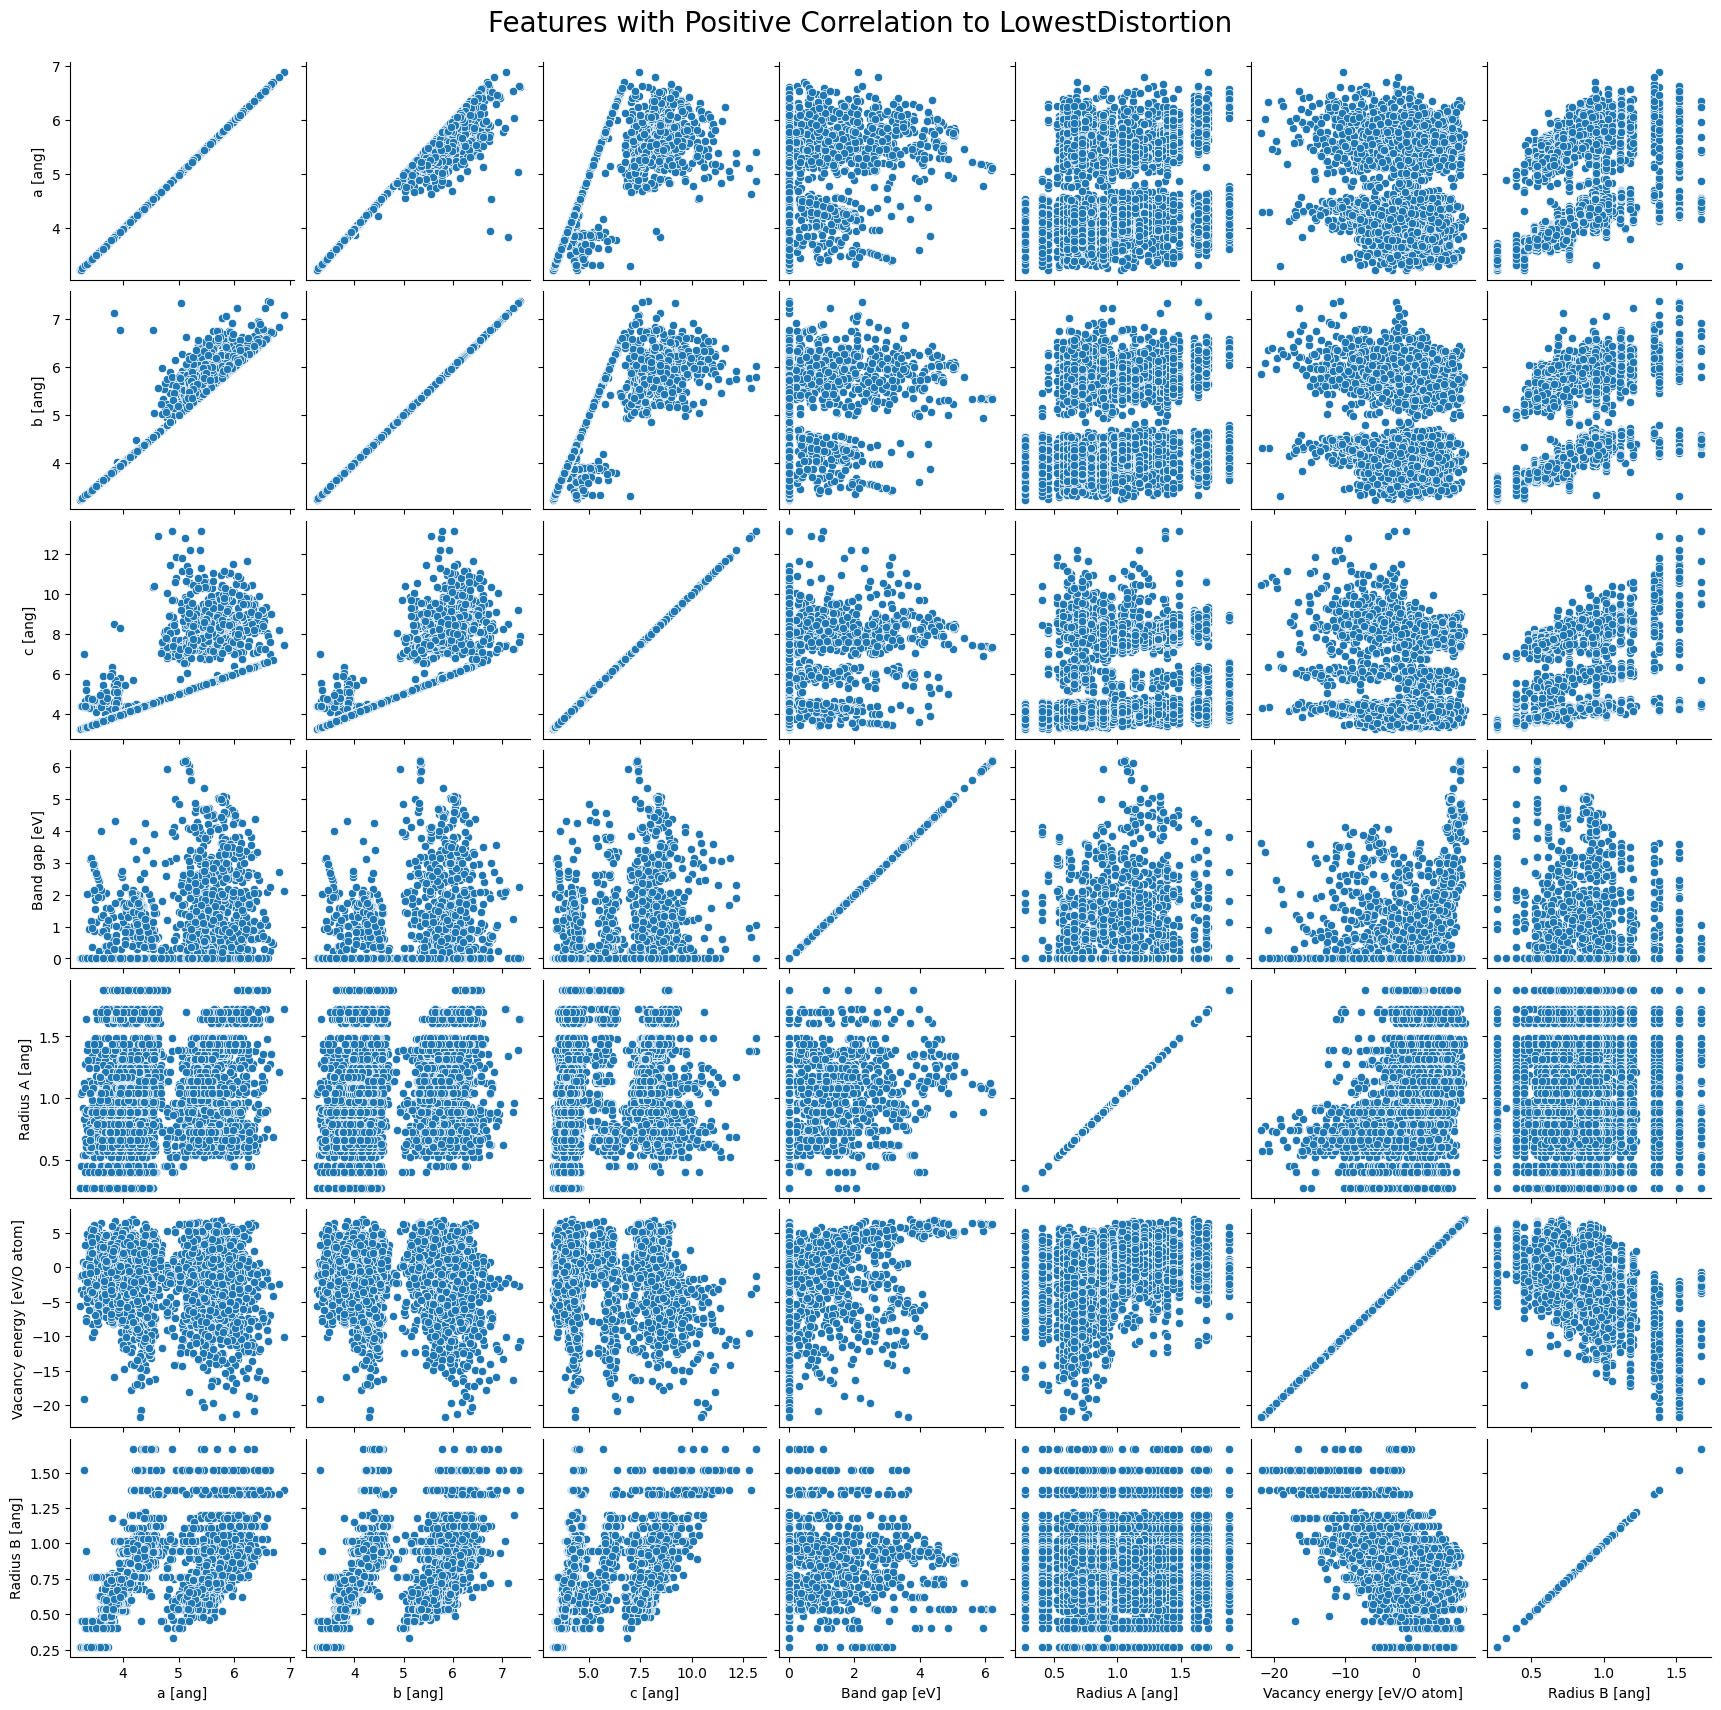

In [6]:
positive_cor= sns.pairplot(data=DFT[DFT.corr()["LowestDist"].sort_values(ascending=False)[1:8].index],
                           diag_kind=None,)
positive_cor.fig.subplots_adjust(top = 0.95)
positive_cor.fig.suptitle("Features with Positive Correlation to LowestDistortion", size = 20)
plt.show();

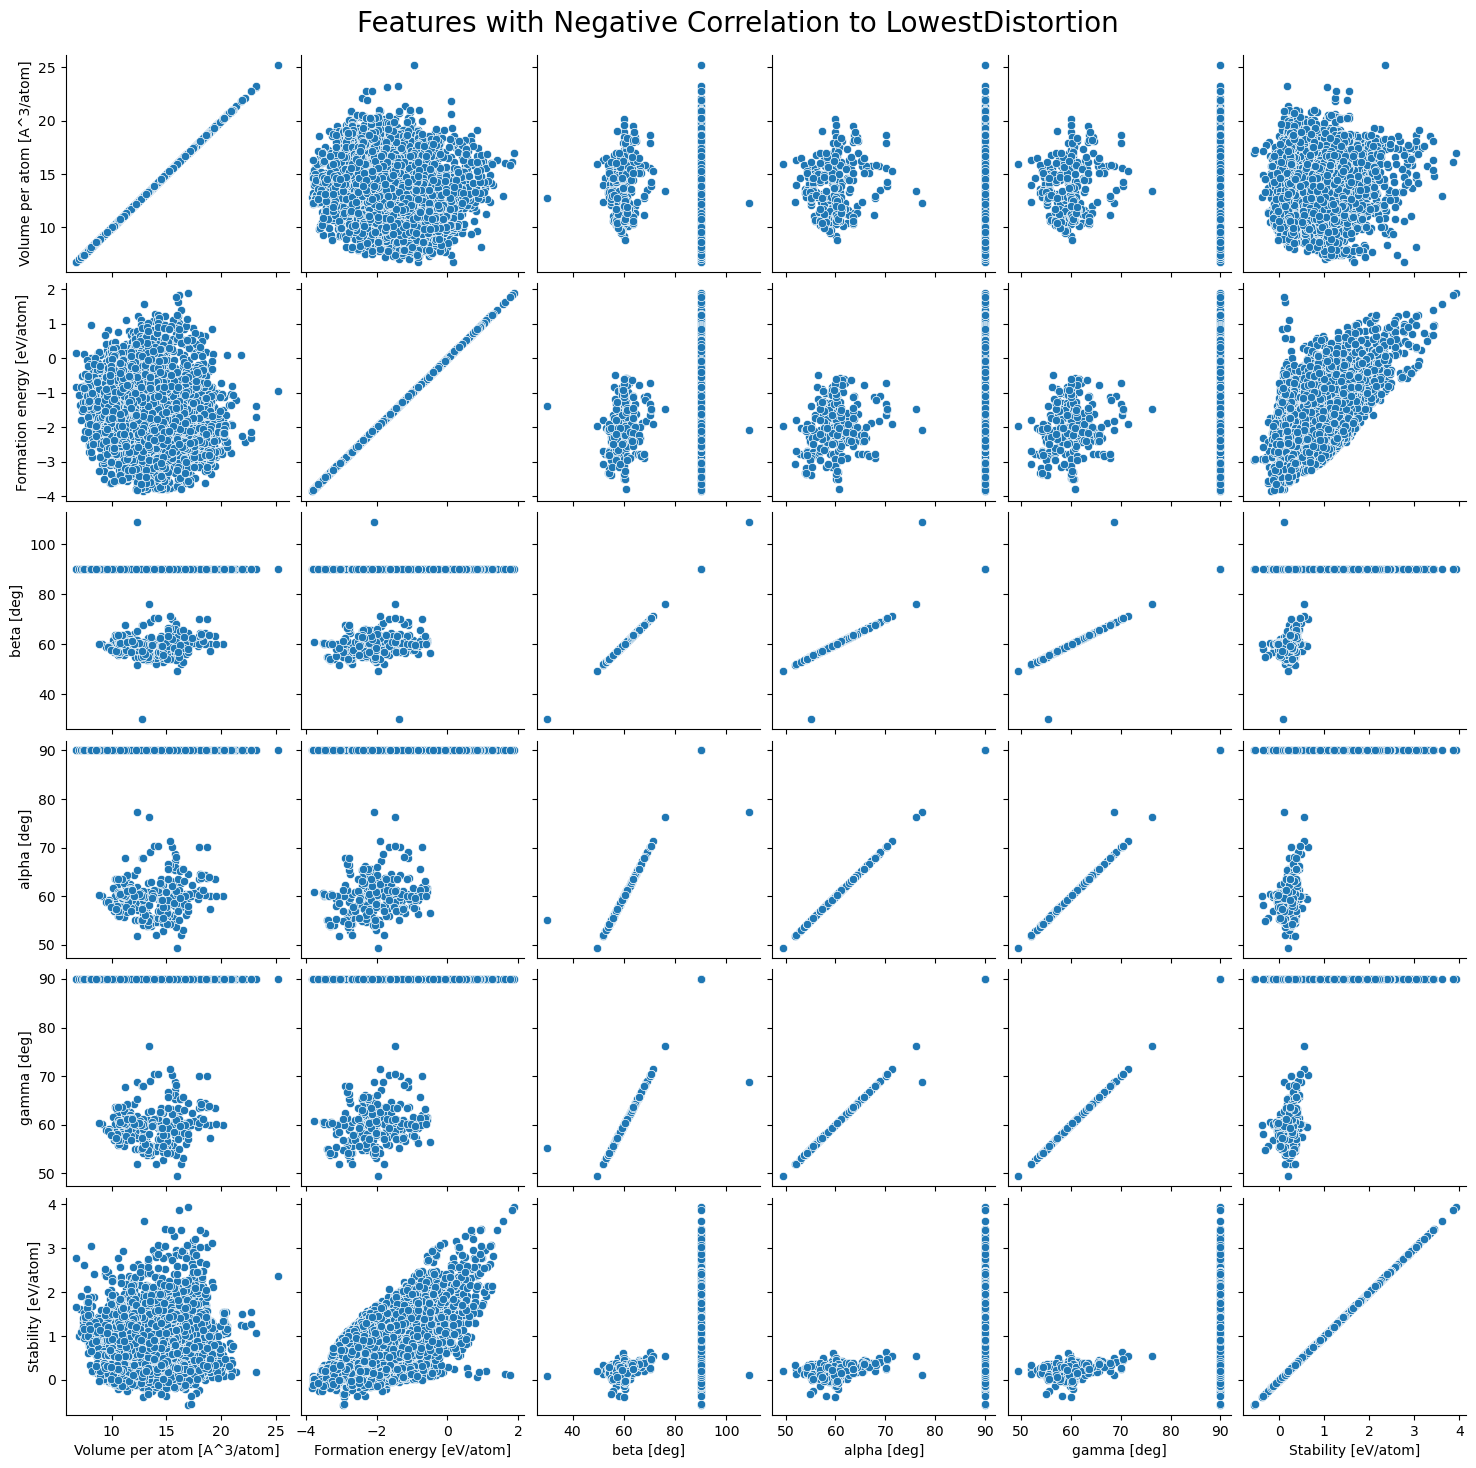

In [7]:
negative_cor=sns.pairplot(data= DFT[DFT.corr()["LowestDist"].sort_values(ascending=False)[8:].index],
                          diag_kind = None)
negative_cor.fig.subplots_adjust(top = 0.95)
negative_cor.fig.suptitle("Features with Negative Correlation to LowestDistortion", size=20)
plt.show();

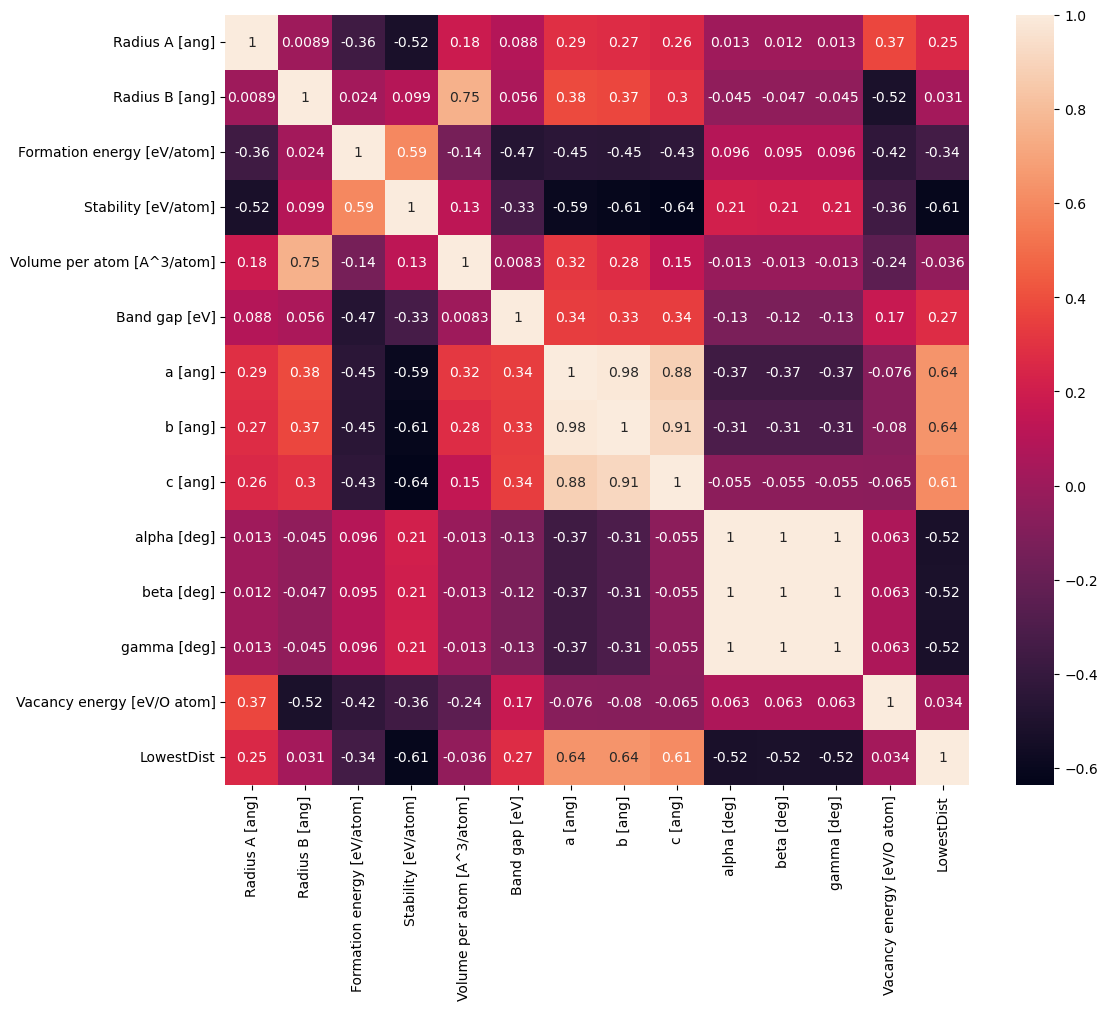

In [8]:
plt.figure(figsize=(12,10))
sns.heatmap(DFT.corr(),annot=True );

## Section 2: Define Models

In [32]:
#LogisticRegression classifier
def log_reg_model():
    """ 
    This function applies logistic regression. The preprocessing includes both StandardScaler and 
    PolynomialFeature stpes 
    """
    
    # Hpyerparameter tunning: solver Saga works for large multiclass datasets
    # The degree of Polynomial feature is chosen after try out different values
    # Hyperparameter tuning
    param_grid = {
        "scale__with_mean": [True, False],
        "scale__with_std": [True, False],
        "poly__degree": [1, 2],
        "clf__C": [0.05, 0.1, 0.5],
        "clf__penalty": ["l2"],
        "clf__solver": ["saga"],
                    }

    # Build pipeline
    pipe_model = Pipeline([
                            ("scale", StandardScaler()),
                            ("poly", PolynomialFeatures()),
                            ("clf", LogisticRegression(max_iter=10000, random_state=42)),
                            ])
    
     # Perform grid search
    grid_reg = GridSearchCV(
                            pipe_model, 
                            param_grid, 
                            cv=10, 
                            n_jobs=-1, 
                            verbose=2, 
                            scoring="accuracy"
                           )
    grid_reg.fit(X_train, y_train)

    # Extract best parameters
    best_params = grid_reg.best_params_

    # Build final pipeline with best parameters
    reg_final = Pipeline([
        ("scale", StandardScaler(with_mean=best_params["scale__with_mean"], with_std=best_params["scale__with_std"])),
        ("poly", PolynomialFeatures(degree=best_params["poly__degree"])),
        ("clf", LogisticRegression(
                                   C=best_params["clf__C"], 
                                   penalty=best_params["clf__penalty"], 
                                   solver=best_params["clf__solver"], 
                                   max_iter=10000)),
                            ])
    
      # Train and test scores
    train_score = reg_final.fit(X_train, y_train).score(X_train, y_train)
    test_score = reg_final.score(X_test, y_test)

    return reg_final, train_score, test_score
    
       
# RandomForest Classifier
def randfor_model():
    """ 
    This function applies RandomForest classifier on dataset with StandardScaler as preprocessing step
    and it returns the final model with best parameters, and the score for train and test
    """
        
    #Hpyerparameter tunning is limited to only three important paramters of the rf classifeir 
    
    # Hyperparameter tuning is limited to only three important parameters of the rf classifier
    pipe_model = Pipeline(steps=[
                                ("scale", StandardScaler()),
                                ("rf", RandomForestClassifier(random_state=42))
                                ])

    param_grid = {
                "scale__with_mean": [True, False],
                "scale__with_std": [True, False],
                "rf__n_estimators": [10, 50, 100],
                "rf__max_depth":   [4, 5, 6],
                "rf__max_features": [4, 5, 6]
                }

      # Define the GridSearchCV object
    grid_rf=GridSearchCV(
                        pipe_model,
                        param_grid=param_grid,
                        cv=10,
                        n_jobs=-1,
                        verbose=2,
                        scoring="accuracy"
                        )

    # Fit the GridSearchCV object
    grid_rf.fit(X_train, y_train)

    # Extract the best parameters
    best_params = grid_rf.best_params_

    # Define the final pipeline with the best parameters
    rf_final=make_pipeline(
        StandardScaler(with_mean=best_params['scale__with_mean'], with_std=best_params['scale__with_std']),
        RandomForestClassifier(
                                n_estimators=best_params['rf__n_estimators'],
                                max_depth=best_params['rf__max_depth'],
                                max_features=best_params['rf__max_features']
                                )
                           )

    # Calculate the score of the trained and test datasets
    train_score=rf_final.fit(X_train, y_train).score(X_train, y_train)
    test_score=rf_final.score(X_test, y_test)

    return rf_final, train_score, test_score


#KNearestNeighbor Classifier
def knn_model():
    """
    This function applies KNN model on the dataset, with StanddardScaling as a preprocessing step.
    """
   
    # Hyperparameter tuning for KNeighbors Classifier
    param_grid = {
        'scale__with_mean': [True, False],
        'scale__with_std': [True, False],
        'knn__n_neighbors': [3, 4, 5],
        'knn__leaf_size': [2, 3, 4],
        'knn__p': [1, 2]
                }
    
    pipe_model = Pipeline(steps=[
                                ('scale', StandardScaler()),
                                ('knn', KNeighborsClassifier())
                                ])
        
    grid_knn = GridSearchCV(
                            pipe_model, 
                            param_grid=param_grid, 
                            cv=10, 
                            n_jobs=-1, 
                            scoring='accuracy')
    
    grid_knn.fit(X_train, y_train)
  
    # Assigning the best parameters found by GridSearch to variables to be used in the model
    best_params = grid_knn.best_params_
    knn_final = make_pipeline(
                        StandardScaler(with_mean=best_params['scale__with_mean'], with_std=best_params['scale__with_std']),
                        KNeighborsClassifier(
                                            n_neighbors=best_params['knn__n_neighbors'],
                                            leaf_size=best_params['knn__leaf_size'],
                                            p=best_params['knn__p']
                                )
                            )
    
    # The score of trained and test datasets 
    train_score=knn_final.fit(X_train, y_train).score(X_train, y_train)
    test_score=knn_final.score(X_test, y_test)


    return knn_final, train_score, test_score


# AdaBoost Classifeir 
def ada_boost_model():
    """ 
    AdaBoost Classifier is implemented with StandardScaler as preprocessing step.
    """
    
    # Hyperparameter tuning for AdaBoost Classifier. It is important to find the best max_depth for base_estimator 
    
    param_grid = {
                "scale__with_mean": [True, False],
                "scale__with_std": [True, False],
                "ada__n_estimators": [5, 10, 50],
                "ada__learning_rate": [0.01, 0.1, 1],
                "ada__base_estimator": [DecisionTreeClassifier(max_depth=d) for d in [5, 6, 7]]
                }
    
    pipe_model = Pipeline(steps=[
                                ("scale", StandardScaler()),
                                ("ada", AdaBoostClassifier(algorithm="SAMME"))
                                ])

    grid_ada = GridSearchCV(
                            pipe_model, 
                            param_grid, 
                            cv=10, 
                            n_jobs=-1, 
                            scoring="accuracy"
                            )
    
    grid_ada.fit(X_train, y_train)
    
      # Assigning the best parameters found by GridSearch to variables to be used in the model
    best_params = grid_ada.best_params_
    
    ada_final = make_pipeline(
                            StandardScaler(with_mean=best_params["scale__with_mean"], with_std=best_params["scale__with_std"]), 
                            AdaBoostClassifier(
                                               estimator=best_params["ada__base_estimator"], 
                                               n_estimators=best_params["ada__n_estimators"], 
                                               learning_rate=best_params["ada__learning_rate"])
                                                )
    
    # Calculating the score of trained and test datasets from AdaBoost Classifier using cross-validation
    train_score=ada_final.fit(X_train, y_train).score(X_train, y_train)
    test_score =ada_final.score(X_test, y_test)

    return ada_final, train_score, test_score
    

# Provide the name of models and their functions which were defined previously

def get_models():
    """ Returns all models as a list """
    return [log_reg_model, randfor_model, knn_model, ada_boost_model]

def score(model_name, model):
    """ Returns the score and classification report as a dictionary """
    y_pred = model[0].predict(X_test)
    report = classification_report(y_test, y_pred, output_dict = True)
    macro_ave = report["macro avg"]
    weighted_ave = report["weighted avg"]
    score_dict = {
        f"{model_name}_macro_ave": macro_ave,
        f"{model_name}_weighted_ave": weighted_ave,
        f"score_train_{model_name}": model[1],
        f"score_test_{model_name}": model[2]
    }
    return score_dict

# A loop over all models to print the scores and classification report
for model in get_models():
    model_name = model.__name__
    model_instance = model()
    scores = score(model_name, model_instance)
    print(f"{model_name} scores:\n{scores}\n")



Fitting 10 folds for each of 24 candidates, totalling 240 fits
log_reg_model scores:
{'log_reg_model_macro_ave': {'precision': 0.9905890804597701, 'recall': 0.9694266994266995, 'f1-score': 0.979484148399421, 'support': 1475}, 'log_reg_model_weighted_ave': {'precision': 0.9965511396843951, 'recall': 0.9966101694915255, 'f1-score': 0.9965322033027174, 'support': 1475}, 'score_train_log_reg_model': 0.9959290491421925, 'score_test_log_reg_model': 0.9966101694915255}

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
randfor_model scores:
{'randfor_model_macro_ave': {'precision': 0.9716774425287357, 'recall': 0.945888615888616, 'f1-score': 0.9579056524878107, 'support': 1475}, 'randfor_model_weighted_ave': {'precision': 0.9922787356321838, 'recall': 0.9925423728813559, 'f1-score': 0.9923301011580031, 'support': 1475}, 'score_train_randfor_model': 0.9965106135504507, 'score_test_randfor_model': 0.9925423728813559}

knn_model scores:
{'knn_model_macro_ave': {'precision': 0.9819

C:\Users\Ali Baghi Zadeh\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


ada_boost_model scores:
{'ada_boost_model_macro_ave': {'precision': 0.9983477011494253, 'recall': 0.9694266994266995, 'f1-score': 0.9829086989860785, 'support': 1475}, 'ada_boost_model_weighted_ave': {'precision': 0.9966204948373272, 'recall': 0.9966101694915255, 'f1-score': 0.9965258241399894, 'support': 1475}, 'score_train_ada_boost_model': 1.0, 'score_test_ada_boost_model': 0.9966101694915255}



## Section 4: Stacking and final model

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Fitting 10 folds for each of 108 candidates, totalling 1080 fits


C:\Users\Ali Baghi Zadeh\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


the train score is  0.997092177958709
the test score is  0.9966101694915255


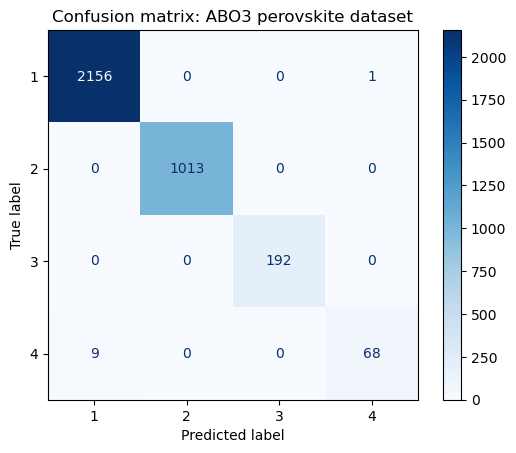

The percentage of the true lables predicted by the model 99.66101694915254 % 

Total Duration of Calculation is: 0:00:50.234251


In [33]:
#
# The base learners are combination of regression, KMeans and tree based algirithm 

base_learner=[
             ("base_lr", log_reg_model()[0]),
             ("base_rf", randfor_model()[0]), 
             ("base_knn", knn_model()[0])
             ]

# The final classifier is AdaBoost 
clf=StackingClassifier(estimators=base_learner, final_estimator=ada_boost_model()[0], cv=10, n_jobs=4)

start_time=datetime.now()

# Calculating the scoring for the train and test datasets
print("the train score is ",clf.fit(X_train, y_train).score(X_train, y_train))
print("the test score is ",clf.score(X_test, y_test))

# Plotting the confusion matrix as an interactive for label prediction
from sklearn.metrics import ConfusionMatrixDisplay

clf_display=ConfusionMatrixDisplay.from_estimator(clf, 
                                                  X_train,
                                                  y_train,
                                                  labels=clf.classes_,
                                                  cmap=plt.cm.Blues,
                                                  colorbar=True)
clf_display.ax_.set_title("Confusion matrix: ABO3 perovskite dataset")
plt.show()

y_pred = clf.predict(X_test)

# This is equivalent to test_score
print(f"The percentage of the true lables predicted by the model {len(y_test[y_test == y_pred])*100/len(y_test)} %", "\n")

end_time=datetime.now()

print(f"Total Duration of Calculation is: {(end_time - start_time)}")